In [1]:
import numpy as np
import pandas as pd
from pysr import PySRRegressor
from scipy.integrate import solve_ivp
from lmfit import Model, Parameters
import matplotlib.pyplot as plt
import matplotlib.colors as col
#Have nice axes with LaTeX
plt.rcParams["text.usetex"] = True

# Define constants
G = 6.67e-11
m1, m2 = 10 * 1.9e30, 10 * 1.9e30
m = m1 + m2
qstan = m2/m1
c = 299792458

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [148]:
# Function for the differential equation
def dedx(x: list[float], e: list[float], m, eta) -> list[float]:
    x1PN = (-11888 - 14784*eta + e**2 * (87720 - 159600*eta) + e**4 * (171038 - 141708*eta) + e**6 * (11717 - 8288*eta))/(420*(1-e**2)**(9/2))
    e1PN = -(67608 + 228704 * eta + e**2 * (-718008 + 651252*eta) + e**4 * (-125361 + 93184 * eta))/(2520*(1-e**2)**(7/2))
    phi = (1 + 7.260831042*e**2 + 5.844370473*e**4 + 0.8452020270*e**6 + 0.07580633432*e**8 + 0.002034045037*e**10) / (1 - 4.900627291*e**2 + 9.512155497*e**4 - 9.051368575*e**6 + 4.096465525*e**8 - 0.5933309609*e**10 - 0.05427399445*e**12 - 0.009020225634*e**14)
    phi_tilde = (1 + 1.893242666*e**2 - 2.708117333*e**4 + 0.6192474531*e**6 + 0.05008474620*e**8 - 0.01059040781*e**10) / (1 - 4.638007334*e**2 + 8.716680569*e**4 - 8.451197591*e**6 + 4.435922348*e**8 - 1.199023304*e**10 + 0.1398678608*e**12 - 0.004254544193*e**14)
    x1_5PN = 64/5*4*np.pi*phi
    e1_5PN = 32/5*985/48*np.pi*(192/985*np.sqrt(1-e**2)/e**2 * (np.sqrt(1-e**2)*phi - phi_tilde))
    x2PN = 1/(45360 * (1-e**2)**(11/2)) * (-360224 + 4514976*eta + 1903104*eta**2 + e**2*(-92846560 + 15464736*eta + 61282032*eta**2) + e**4*(783768 - 207204264*eta + 166506060*eta**2) + e**6*(83424402 - 123108426*eta + 64828848*eta**2) + e**8*(3523113 - 3259980*eta + 1964256*eta**2) - 3024*(96 + 4268*e**2 + 4386*e**4 + 175*e**6)*(-5 + 2*eta)*np.sqrt(1-e**2))
    e2PN = 1/(30240*(1-e**2)**(9/2)) * (-15198032 + 13509360*eta + 4548096*eta**2 + e**2*(-36993396 - 35583228*eta + 48711348*eta**2) + e**4*(46579718 - 78112266*eta + 42810096*eta**2) + e**6*(3786543 - 4344852*eta + 2758560*eta**2) - 1008*(2672 + 6963*e**2+565*e**4)*(-5+2*eta)*np.sqrt(1-e**2))
    return -e/x * ((304 + 121*e**2)/(15*(1-e**2)**(5/2)) + e1PN * x + e1_5PN*x**(3/2) + e2PN * x**2) / ((192 + 584 * e**2 + 74 * e**4)/(15*(1-e**2)**(7/2)) + x1PN * x + x1_5PN * x**(3/2) + x2PN * x**2)

In [107]:
N = 100

e0sp = np.linspace(0, 0.3, N)

es = []
xs = []
e0s = []
xstart = (G*(m)*np.pi*10/c**3)**(2/3)

for e0 in e0sp:
    sol = solve_ivp(
        lambda x, y: dedx(x, y),
        [xstart, 1/6],
        [e0],
        t_eval=np.linspace(xstart, 1/6, N),
    )
    e0s.extend(np.repeat(e0, N))
    xs.extend(sol.t)
    es.extend(sol.y[0])

C:\Users\aminr\AppData\Local\Temp\ipykernel_30816\1332742737.py:9: RuntimeWarning: divide by zero encountered in divide
  e1_5PN = 32/5*985/48*np.pi*(192/985*np.sqrt(1-e**2)/e**2 * (np.sqrt(1-e**2)*phi - phi_tilde))
C:\Users\aminr\AppData\Local\Temp\ipykernel_30816\1332742737.py:9: RuntimeWarning: invalid value encountered in multiply
  e1_5PN = 32/5*985/48*np.pi*(192/985*np.sqrt(1-e**2)/e**2 * (np.sqrt(1-e**2)*phi - phi_tilde))


IndexError: list index out of range

In [ ]:
data = pd.DataFrame({'x': np.asarray(xs), 'e0': np.asarray(e0s)})

In [ ]:
model = PySRRegressor(
    model_selection="accuracy",
    binary_operators=["+", "-", "*", "/", "^"], 
    unary_operators=["log", "exp"], 
    nested_constraints = {"log": {"exp": 0}, "exp": {"log": 0}},
    constraints = {"^": (-1,1)},
    maxsize = 50,
    populations = 50,
    population_size = 50,
    niterations=1000,
    precision=64,
)

In [ ]:
model.fit(data, es)

In [ ]:
model.sympy()

In [108]:
def pysrfit(e0, x):
    e = 0.7437754023095167*e0*(e0**2 + np.exp(e0)**1.311931736620892 - 0.30632593628732413 + 0.06091994064988366/x)/(e0 + x*(1.0833788704690209 - x) + x + (1.2002319584105975*(x**(-12.478775250960325))**1.005249024454688 + 6002214534.5191668)**x) + 0.000343124952877091 # e_0 0-0.3
    return e

In [151]:
def expansion(e0, x, m, eta):
    chi = (x)**(3/2)*c**3/(10*G*m*np.pi)
    D0 = e0*chi**(-19/18) + 3323/1824 * e0**3*(chi**(-19/18) - chi**(-19/6)) + e0**5 * (15994231/6653952*chi**(-19/18) - 11042329/1108992*chi**(-19/6) + 50259743/6653952*chi**(-95/18))
    D2 = ((2833/2016 - 197/72*eta)*(-chi**(-19/18) + chi**(-31/18)))*e0 + ((-9414059/3677184 + 654631/131328*eta)*chi**(-19/18) + (386822573/47803392 - 1482433/131328*eta)*chi**(-31/18) + (11412055/5311488 - 378697/43776*eta)*chi**(-19/6) + (-9414059/1225728 + 654631/43776*eta)*chi**(-23/6))*e0**3 + ((-45311656423/13414367232 + 3150863507/479084544*eta)*chi**(-19/18) + (3061519891285/174386774016 - 11147601665/479084544*eta)*chi**(-31/18) + (37922258765/3229384704 - 1258410131/26615808*eta)*chi**(-19/6) + (-699589093187/9688154112 + 3092267495/26615808*eta)*chi**(-23/6) + (-1182747028465/174386774016 + 24493152461/479084544*eta)*chi**(-95/18) + (711929259595/13414367232 - 49505846855/479084544*eta)*chi**(-107/18))*e0**5
    D3 = 377*np.pi/144*(-chi**(-19/18) + chi**(-37/18))*e0 + (-1252771*np.pi/262656*chi**(-19/18) + 1315151*np.pi/131328*chi**(-37/18) + 396797*np.pi/43776*chi**(-19/6) - 1252771*np.pi/87552*chi**(-25/6))*e0**3 + (-6029825087*np.pi/958169088*chi**(-19/18) + 607032981553*np.pi/27786903552*chi**(-37/18) + 1318556431*np.pi/26615808*chi**(-19/6) - 1422200801*np.pi/13307904*chi**(-25/6) - 1586634546601*np.pi/27786903552*chi**(-95/18) + 94739615555*np.pi/958169088*chi**(-113/18))*e0**5
    D4 = ((77006005/24385536 - 1143767/145152*eta + 43807/10368*eta**2)*chi**(-19/18) + (-8025889/4064256 + 558101/72576*eta - 38809/5184*eta**2)*chi**(-31/18) + (-28850671/24385536 + 27565/145152*eta + 33811/10368*eta**2)*chi**(-43/18))*e0 + ((255890954615/44479217664 - 3800737741/264757248*eta + 145570661/18911232*eta**2)*chi**(-19/18) + (-1095868349309/96371638272 + 65400285919/1720922112*eta - 292039301/9455616*eta**2)*chi**(-31/18) + (-20952382669619/4047608807424 - 385200824731/24092909568*eta + 4301644427/132378624*eta**2)*chi**(-43/18) + (8180980796033/1349202935808 + 14604819923/2676989952*eta - 317361763/14708736*eta**2)*chi**(-19/6) + (32330351815/3569319936 - 10345778159/191213568*eta + 74603309/1050624*eta**2)*chi**(-23/6) + (-9164199307/2118057984 + 1205846917/29417472*eta - 13714021/233472*eta**2)*chi**(-9/2))*e0**3 + ((1231651832357155/162260186038272 - 18293673608177/965834440704*eta + 700659277417/68988174336*eta**2)*chi**(-19/18) + (-8673285852010405/351563736416256 + 506837220151715/6277923864576*eta - 2196077528005/34494087168*eta**2)*chi**(-31/18) + (-4719697288288984795/191953800083275776 - 4676818769915975/87890934104064*eta + 669607180808035/6277923864576*eta**2)*chi**(-43/18) + (27185399185217659/820315384971264 + 48531816604129/1627609890816*eta - 1054593138449/8942911488*eta**2)*chi**(-19/6) + (2402572738143295/28211904774144 - 55792908667709/116257849344*eta + 352402173805/638779392*eta**2)*chi**(-23/6) + (-25186092424407371/273438461657088 + 936816311138573/1627609890816*eta - 1951606822255/2980970496*eta**2)*chi**(-9/2) + (-7937050519029473999/19153800083275776 - 1089957759112387/87890934104064*eta + 1121044759543031/6277923864576*eta**2)*chi**(-95/18) + (-16753611658206725/351563736416256 + 2837648691484435/6277923864576*eta - 24125755174085/34494087168*eta**2)*chi**(-107/18) + (16633441088056655/162260186038272 - 79153315354555/137976348672*eta + 47507268174605/68988174336*eta**2)*chi**(-119/18))*e0**5

    e = D0 + D2 * x + D3 * x**(3/2) + D4 * x**2
    e = np.nan_to_num(e, nan=0.0, posinf=1e10, neginf=-1e10)
    
    return e

In [149]:
N = 1000
eta=0.25
m=20*1.9e30
xstart = (G*m*np.pi*10/c**3)**(2/3)
initialEccentricities = [0.01, 0.05, 0.1, 0.2, 0.3]

# Solve ewuations numerically
solutions = []
Flist = []
xlist = []
for e0 in initialEccentricities:
    sol = solve_ivp(
        lambda x, y: dedx(x, y, m, eta),
        [xstart, 1/6],
        [e0],
        t_eval=np.linspace(xstart, 1/6, N),
    )
    solutions.append(sol.y[0])
    xlist.append(sol.t)
    Flist.append(np.asarray(sol.t)**(3/2)*c**3/(G*m*np.pi))


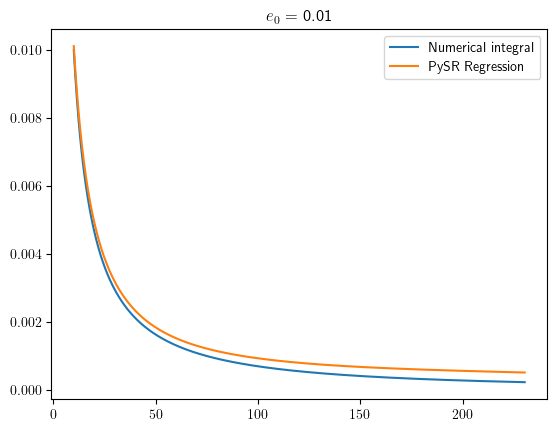

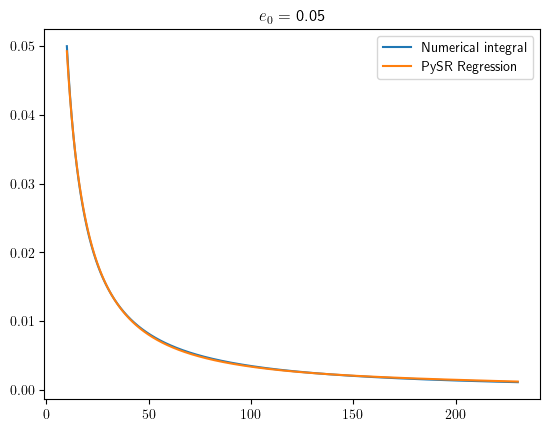

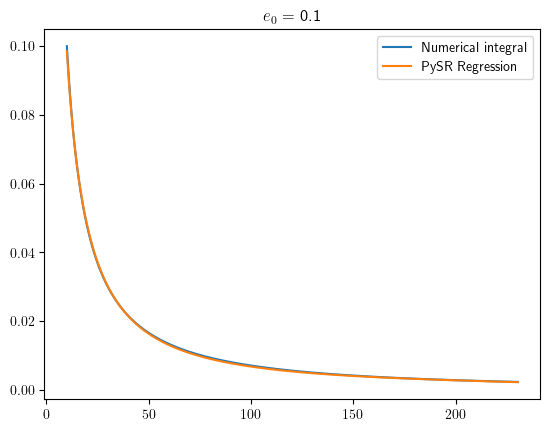

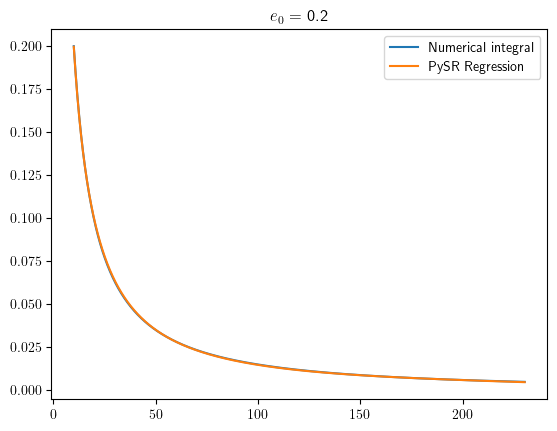

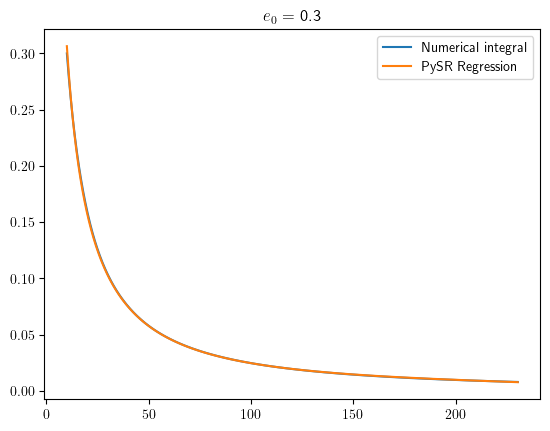

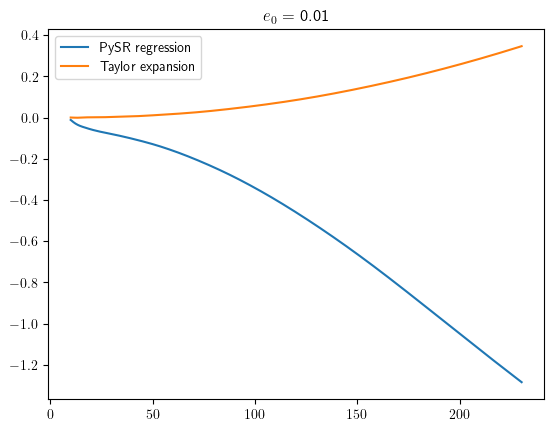

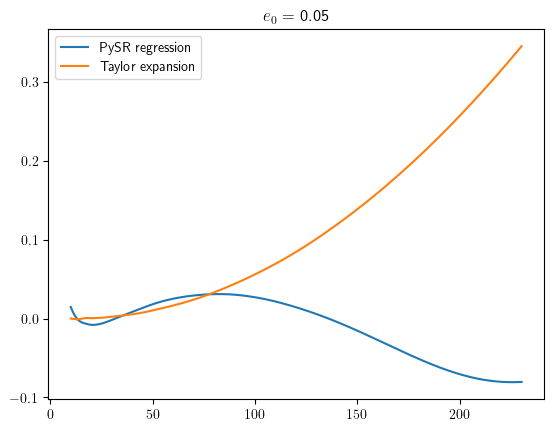

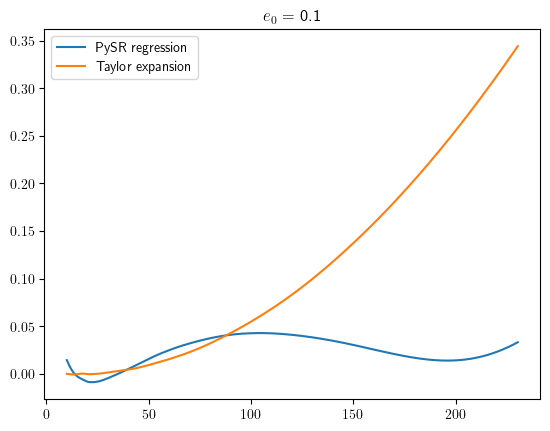

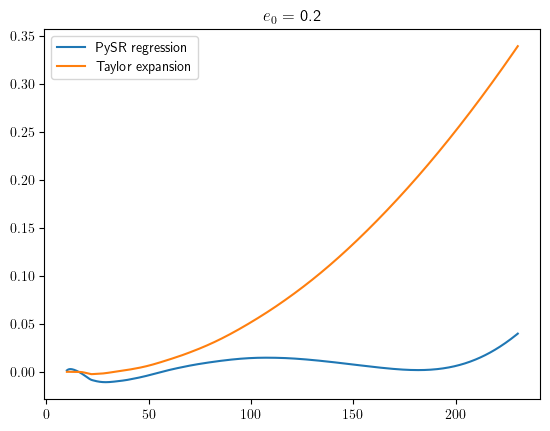

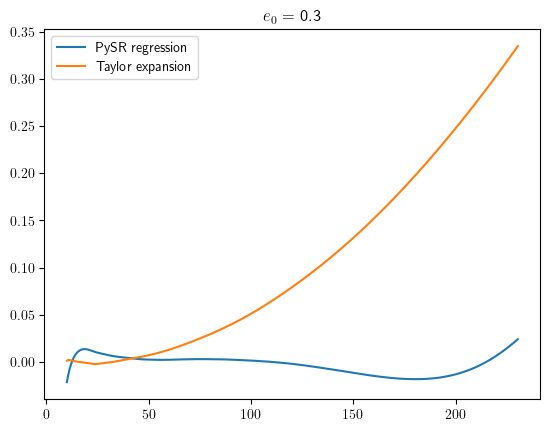

In [153]:
for i, e0 in enumerate(initialEccentricities):
    plt.plot(Flist[i], solutions[i], label = "Numerical integral")
    plt.plot(Flist[i], pysrfit(np.repeat(e0, N), xlist[i]), label="PySR Regression")
    plt.title(rf"$e_0$ = {e0}")
    plt.legend()
    plt.show()

for i, e0 in enumerate(initialEccentricities):
    plt.plot(Flist[i], (solutions[i] - pysrfit(np.repeat(e0, N), xlist[i])) / solutions[i], label = "PySR regression")
    plt.plot(Flist[i], (solutions[i] - expansion(np.repeat(e0, N), xlist[i], m, eta)) / solutions[i], label = "Taylor expansion")
    plt.legend()
    plt.title(rf"$e_0$ = {e0}")
    plt.show()

In [192]:
N = 1000
eta = 0.25
m=20*1.9e30
xstart = (G*m*np.pi*10/c**3)**(2/3)
initialEccentricities = np.linspace(0.05, 0.5, N)

# Solve ewuations numerically
solutions = []
Flist = []
xlist = []
for e0 in initialEccentricities:
    sol = solve_ivp(
        lambda x, y: dedx(x, y, m, eta),
        [xstart, 1/6],
        [e0],
        t_eval=np.linspace(xstart, 1/6, N),
    )
    solutions.append(sol.y[0])
    xlist.append(sol.t)
    Flist.append(np.asarray(sol.t)**(3/2)*c**3/(G*m*np.pi))

C:\Users\aminr\AppData\Local\Temp\ipykernel_30816\1802380105.py:3: RuntimeWarning: invalid value encountered in power
  x1PN = (-11888 - 14784*eta + e**2 * (87720 - 159600*eta) + e**4 * (171038 - 141708*eta) + e**6 * (11717 - 8288*eta))/(420*(1-e**2)**(9/2))
C:\Users\aminr\AppData\Local\Temp\ipykernel_30816\1802380105.py:4: RuntimeWarning: invalid value encountered in power
  e1PN = -(67608 + 228704 * eta + e**2 * (-718008 + 651252*eta) + e**4 * (-125361 + 93184 * eta))/(2520*(1-e**2)**(7/2))
C:\Users\aminr\AppData\Local\Temp\ipykernel_30816\1802380105.py:8: RuntimeWarning: invalid value encountered in sqrt
  e1_5PN = 32/5*985/48*np.pi*(192/985*np.sqrt(1-e**2)/e**2 * (np.sqrt(1-e**2)*phi - phi_tilde))
C:\Users\aminr\AppData\Local\Temp\ipykernel_30816\1802380105.py:9: RuntimeWarning: invalid value encountered in power
  x2PN = 1/(45360 * (1-e**2)**(11/2)) * (-360224 + 4514976*eta + 1903104*eta**2 + e**2*(-92846560 + 15464736*eta + 61282032*eta**2) + e**4*(783768 - 207204264*eta + 166506

In [193]:
xmesh, e0mesh = np.meshgrid(
    np.linspace(xstart, 1/6, N), initialEccentricities
)

Fmesh, e0mesh = np.meshgrid(
    np.linspace(10, (1/6)**(3/2)*c**3/(G*m*np.pi), N), initialEccentricities
)
emesh = np.array(solutions)

In [194]:
eregreshmesh = pysrfit(e0mesh, xmesh)
expandmesh = np.array(expansion(e0mesh, xmesh, m, eta), dtype=float)

combined_data = np.array([np.abs(emesh - eregreshmesh) / emesh, np.abs(emesh - expandmesh) / emesh])

_min, _max = np.amin(combined_data), np.amax(combined_data)

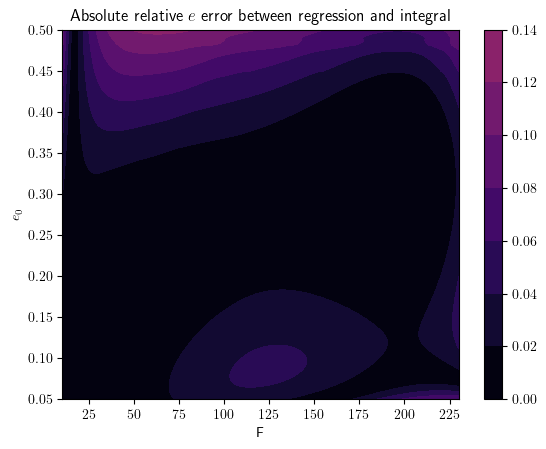

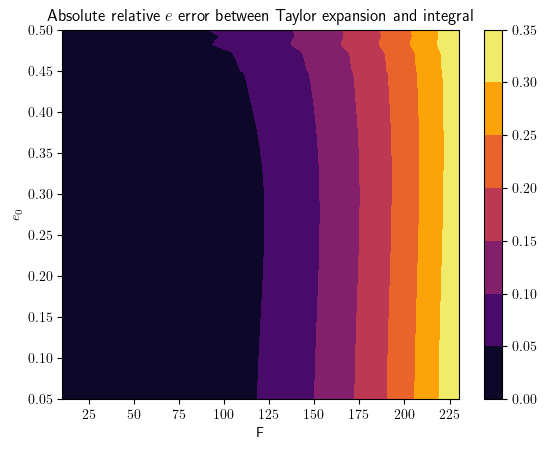

In [195]:
plt.contourf(Fmesh, e0mesh, np.abs(emesh - eregreshmesh)/emesh, cmap="inferno", vmin=_min, vmax=_max) #norm=col.LogNorm(_min, _max))
plt.ylabel(r"$e_0$")
plt.xlabel(r"F")
plt.title(r"Absolute relative $e$ error between regression and integral")
plt.colorbar()
plt.show()

plt.contourf(Fmesh, e0mesh, np.abs(emesh - expandmesh) /emesh, cmap="inferno", vmin=_min, vmax=_max) #norm=col.LogNorm(_min, _max))
plt.ylabel(r"$e_0$")
plt.xlabel(r"F")
plt.title(r"Absolute relative $e$ error between Taylor expansion and integral")
plt.colorbar()
plt.show()

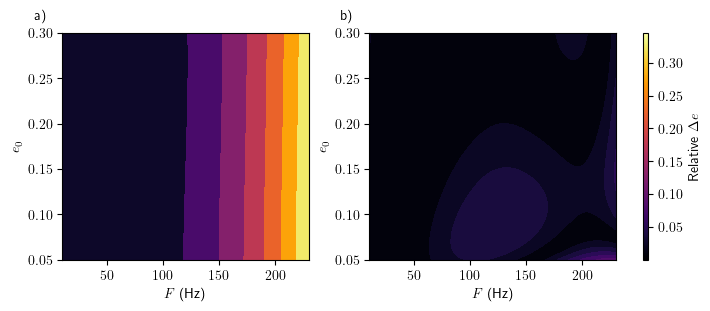

In [187]:
from matplotlib.cm import ScalarMappable
from matplotlib.transforms import ScaledTranslation

# Create the figure with subplots
fig, axs = plt.subplot_mosaic([['a)', 'b)']], layout='constrained', figsize=(7, 3))

# Plot for a)
im_a = axs['a)'].contourf(Fmesh, e0mesh, np.abs(emesh - expandmesh) /emesh, cmap="inferno", vmin=_min, vmax=_max) #norm=col.LogNorm(_min, _max))
axs['a)'].set_ylabel(r"$e_0$")
axs['a)'].set_xlabel(r"$F$ (Hz)")

# Plot for b)
im_b = axs['b)'].contourf(Fmesh, e0mesh, np.abs(emesh - eregreshmesh)/emesh, cmap="inferno", vmin=_min, vmax=_max) #norm=col.LogNorm(_min, _max))
axs['b)'].set_ylabel(r"$e_0$")
axs['b)'].set_xlabel(r"$F$ (Hz)")

# Add labels to the subplots
for label, ax in axs.items():
    ax.text(0.0, 1.0, label, transform=(ax.transAxes + ScaledTranslation(-20 / 72, +7 / 72, fig.dpi_scale_trans)),
            fontsize='medium', va='bottom', fontfamily='sans-serif')

# Create a single colorbar
sm = ScalarMappable(cmap="inferno", norm=plt.Normalize(vmin=_min, vmax=_max))
cbar = fig.colorbar(sm, ax=list(axs.values()), orientation='vertical', aspect=50)
cbar.ax.set_ylabel(r"Relative $\Delta e$")

# plt.show()
plt.savefig("2pncomparisonmosaic.png", dpi=300, bbox_inches='tight')

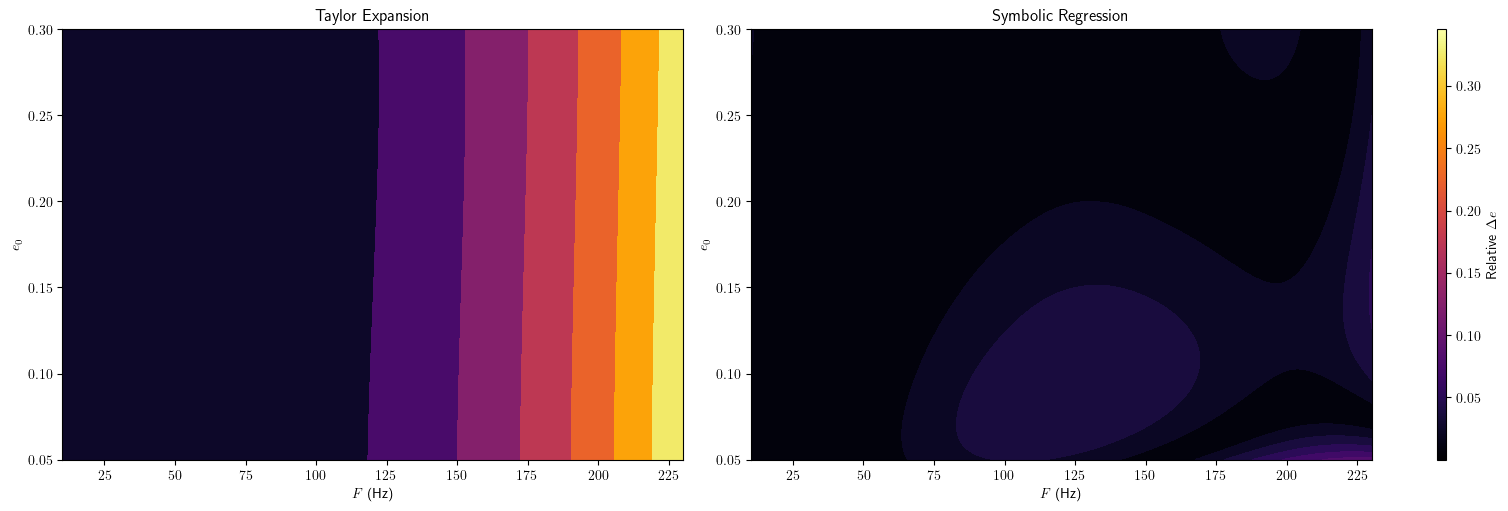

In [171]:
from matplotlib.cm import ScalarMappable
from matplotlib.transforms import ScaledTranslation

# Create the figure with subplots
fig, axs = plt.subplot_mosaic([['a)', 'b)']], layout='constrained', figsize=(15, 5))

# Plot for a)
im_a = axs['a)'].contourf(Fmesh, e0mesh, np.abs(emesh - expandmesh) /emesh, cmap="inferno", vmin=_min, vmax=_max) #norm=col.LogNorm(_min, _max))
axs['a)'].set_ylabel(r"$e_0$")
axs['a)'].set_xlabel(r"$F$ (Hz)")
axs['a)'].set_title("Taylor Expansion")

# Plot for b)
im_b = axs['b)'].contourf(Fmesh, e0mesh, np.abs(emesh - eregreshmesh)/emesh, cmap="inferno", vmin=_min, vmax=_max) #norm=col.LogNorm(_min, _max))
axs['b)'].set_ylabel(r"$e_0$")
axs['b)'].set_xlabel(r"$F$ (Hz)")
axs['b)'].set_title("Symbolic Regression")

# # Add labels to the subplots
# for label, ax in axs.items():
#     ax.text(0.0, 1.0, label, transform=(ax.transAxes + ScaledTranslation(-20 / 72, +7 / 72, fig.dpi_scale_trans)),
#             fontsize='medium', va='bottom', fontfamily='sans-serif')

# Create a single colorbar
sm = ScalarMappable(cmap="inferno", norm=plt.Normalize(vmin=_min, vmax=_max))
cbar = fig.colorbar(sm, ax=list(axs.values()), orientation='vertical', aspect=50)
cbar.ax.set_ylabel(r"Relative $\Delta e$")

# plt.show()
plt.savefig("ppt_2pncomparisonmosaic.png", dpi=300, bbox_inches='tight')

In [178]:
from scipy.integrate import quad, romberg
import numpy as np

eta = 0.25
G = 6.67e-11
m = 20 * 2e30
c = 299792458

In [196]:
N = 1000
eta = 0.25
m = 20*1.9e30
xstart = (G*m*np.pi*10/c**3)**(2/3)
initialEccentricities = [0.1, 0.2, 0.3]

# Solve ewuations numerically
solutions = []
xlist = []
for e0 in initialEccentricities:
    sol = solve_ivp(
        lambda x, y: dedx(x, y, m, eta),
        [xstart, 1/6],
        [e0],
        t_eval=np.linspace(xstart, 1/6, N),
    )
    solutions.append(sol.y[0])
    xlist.append(sol.t)
    F = np.asarray(sol.t)**(3/2)*c**3/(G*m*np.pi)

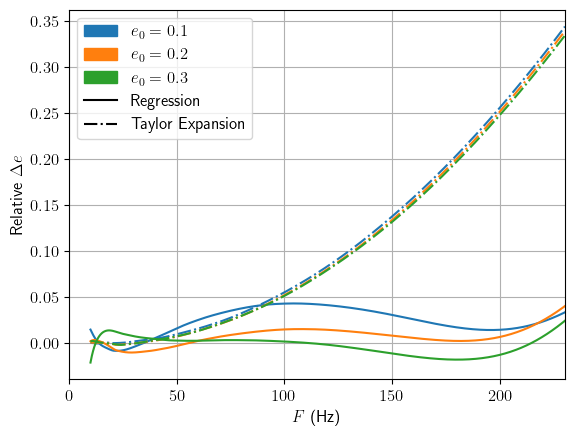

In [181]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

fig, ax = plt.subplots()

# Plotting the lines with different colors and linestyles
colors = ['C0', 'C1', 'C2']
labels = [r"$e_0=0.1$", r"$e_0=0.2$", r"$e_0=0.3$"]
linestyle_labels = ["Regression", "Taylor Expansion"]
linestyles = ["solid", "dashdot"]

# Plotting the lines
for i, (color, label) in enumerate(zip(colors, labels)):
    e0 = 0.1 + i * 0.1
    ax.plot(F, (solutions[i] - pysrfit(e0, xlist[i])) / solutions[i], color=color, linestyle="solid")
    ax.plot(F, (solutions[i] - expansion(e0, xlist[i], m, eta)) / solutions[i], color=color, linestyle="dashdot")

# Custom legend for linestyles
linestyle_legend = [
    Line2D([0], [0], color='black', linestyle=ls, label=label)
    for ls, label in zip(linestyles, linestyle_labels)
]

# Custom legend for colors
color_boxes = [
    Patch(facecolor=color, edgecolor=color, label=label)
    for color, label in zip(colors, labels)
]

# Combine legends
handles, _ = ax.get_legend_handles_labels()
handles = color_boxes + linestyle_legend
labels = [label for label in labels] + linestyle_labels
ax.legend(handles, labels, fontsize=12)

# Setting plot limits and labels
ax.set_xlim(0, F[-1])
ax.grid()
ax.set_ylabel(r"Relative $\Delta e$", fontsize=12)
ax.set_xlabel(r"$F$ (Hz)", fontsize=12)

# Increase tick label size
ax.tick_params(axis='both', which='major', labelsize=12)

# Save the plot
plt.savefig("2pnpysrcompare.png", dpi=300, bbox_inches='tight')

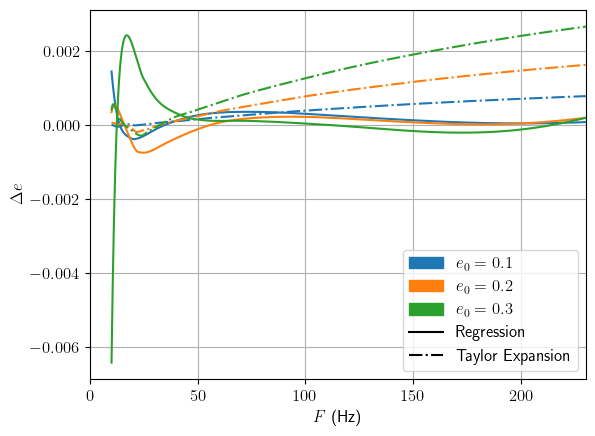

In [197]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

fig, ax = plt.subplots()

# Plotting the lines with different colors and linestyles
colors = ['C0', 'C1', 'C2']
labels = [r"$e_0=0.1$", r"$e_0=0.2$", r"$e_0=0.3$"]
linestyle_labels = ["Regression", "Taylor Expansion"]
linestyles = ["solid", "dashdot"]

# Plotting the lines
for i, (color, label) in enumerate(zip(colors, labels)):
    e0 = 0.1 + i * 0.1
    ax.plot(F, (solutions[i] - pysrfit(e0, xlist[i])), color=color, linestyle="solid")
    ax.plot(F, (solutions[i] - expansion(e0, xlist[i], m, eta)), color=color, linestyle="dashdot")

# Custom legend for linestyles
linestyle_legend = [
    Line2D([0], [0], color='black', linestyle=ls, label=label)
    for ls, label in zip(linestyles, linestyle_labels)
]

# Custom legend for colors
color_boxes = [
    Patch(facecolor=color, edgecolor=color, label=label)
    for color, label in zip(colors, labels)
]

# Combine legends
handles, _ = ax.get_legend_handles_labels()
handles = color_boxes + linestyle_legend
labels = [label for label in labels] + linestyle_labels
ax.legend(handles, labels, fontsize=12)

# Setting plot limits and labels
ax.set_xlim(0, F[-1])
ax.grid()
ax.set_ylabel(r"$\Delta e$", fontsize=12)
ax.set_xlabel(r"$F$ (Hz)", fontsize=12)

# Increase tick label size
ax.tick_params(axis='both', which='major', labelsize=12)

# Save the plot
plt.savefig("2pnpysrcompareabs.png", dpi=300, bbox_inches='tight')

In [188]:
N = 1000
m1, m2 = 3*1.9e30, 2*1.9e30
m = m1+m2
eta = m1*m2/m**2
initialEccentricities = np.linspace(0.05, 0.3, N)
xstart = (G*m*np.pi*10/c**3)**(2/3)

# Solve ewuations numerically
solutions = []
Flist = []
xlist = []
for e0 in initialEccentricities:
    sol = solve_ivp(
        lambda x, y: dedx(x, y, m, eta),
        [xstart, 1/6],
        [e0],
        t_eval=np.linspace(xstart, 1/6, N),
    )
    solutions.append(sol.y[0])
    xlist.append(sol.t)
    Flist.append(np.asarray(sol.t)**(3/2)*c**3/(G*m*np.pi))

In [189]:
xmesh, e0mesh = np.meshgrid(
    np.linspace(xstart, 1/6, N), initialEccentricities
)

Fmesh, e0mesh = np.meshgrid(
    np.linspace(10, (1/6)**(3/2)*c**3/(G*m*np.pi), N), initialEccentricities
)
emesh = np.array(solutions)

In [190]:
eregreshmesh = pysrfit(e0mesh, xmesh)
expandmesh = np.array(expansion(e0mesh, xmesh, m, eta), dtype=float)

combined_data = np.array([np.abs(emesh - eregreshmesh) / emesh, np.abs(emesh - expandmesh) / emesh])

_min, _max = np.amin(combined_data), np.amax(combined_data)

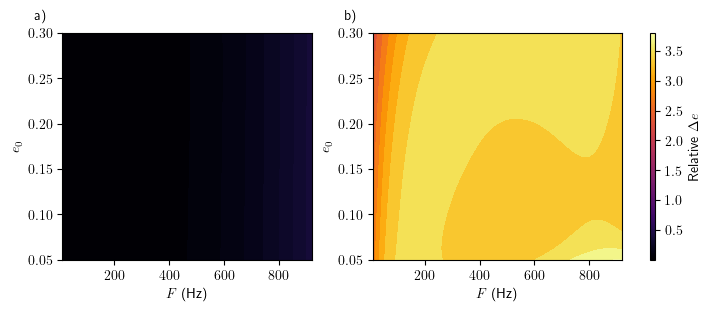

In [191]:
from matplotlib.cm import ScalarMappable
from matplotlib.transforms import ScaledTranslation

# Create the figure with subplots
fig, axs = plt.subplot_mosaic([['a)', 'b)']], layout='constrained', figsize=(7, 3))

# Plot for a)
im_a = axs['a)'].contourf(Fmesh, e0mesh, np.abs(emesh - expandmesh) /emesh, cmap="inferno", vmin=_min, vmax=_max)#, norm=col.LogNorm(_min, _max))
axs['a)'].set_ylabel(r"$e_0$")
axs['a)'].set_xlabel(r"$F$ (Hz)")

# Plot for b)
im_b = axs['b)'].contourf(Fmesh, e0mesh, np.abs(emesh - eregreshmesh)/emesh, cmap="inferno", vmin=_min, vmax=_max)#, norm=col.LogNorm(_min, _max))
axs['b)'].set_ylabel(r"$e_0$")
axs['b)'].set_xlabel(r"$F$ (Hz)")

# Add labels to the subplots
for label, ax in axs.items():
    ax.text(0.0, 1.0, label, transform=(ax.transAxes + ScaledTranslation(-20 / 72, +7 / 72, fig.dpi_scale_trans)),
            fontsize='medium', va='bottom', fontfamily='sans-serif')

# Create a single colorbar
sm = ScalarMappable(cmap="inferno", norm=plt.Normalize(vmin=_min, vmax=_max))
cbar = fig.colorbar(sm, ax=list(axs.values()), orientation='vertical', aspect=50)
cbar.ax.set_ylabel(r"Relative $\Delta e$")

# plt.show()
plt.savefig("2pnlowmassmosaic.png", dpi=300, bbox_inches='tight')

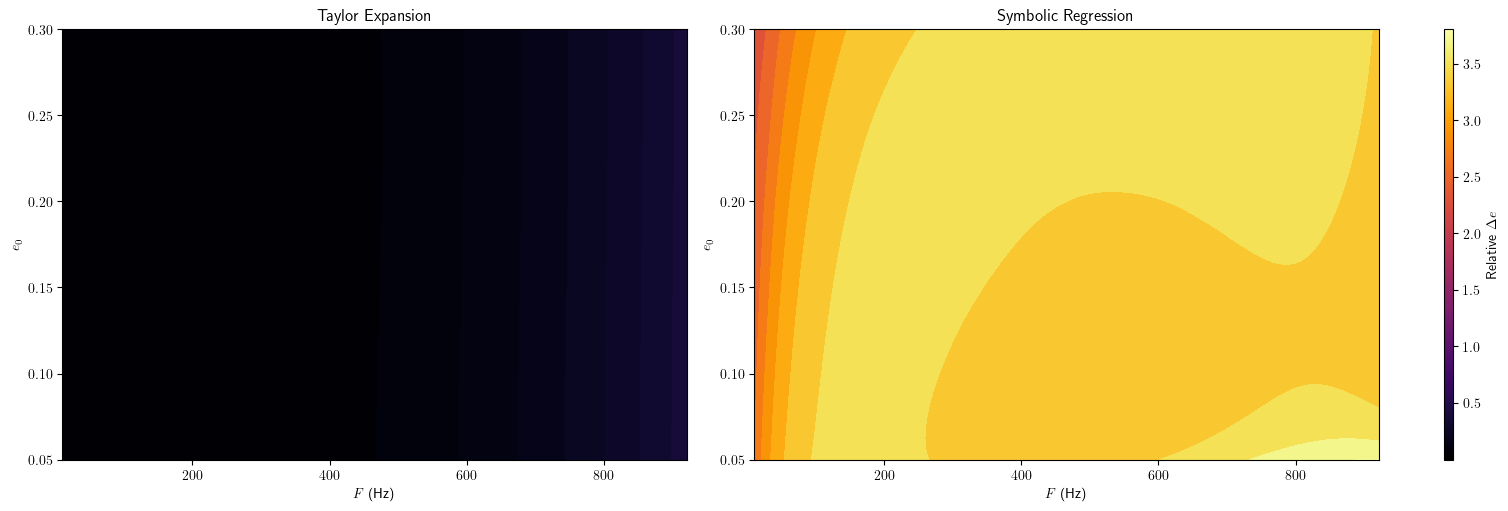

In [177]:
from matplotlib.cm import ScalarMappable
from matplotlib.transforms import ScaledTranslation

# Create the figure with subplots
fig, axs = plt.subplot_mosaic([['a)', 'b)']], layout='constrained', figsize=(15, 5))

# Plot for a)
im_a = axs['a)'].contourf(Fmesh, e0mesh, np.abs(emesh - expandmesh) /emesh, cmap="inferno", vmin=_min, vmax=_max)#, norm=col.LogNorm(_min, _max))
axs['a)'].set_ylabel(r"$e_0$")
axs['a)'].set_xlabel(r"$F$ (Hz)")
axs["a)"].set_title("Taylor Expansion")

# Plot for b)
im_b = axs['b)'].contourf(Fmesh, e0mesh, np.abs(emesh - eregreshmesh)/emesh, cmap="inferno", vmin=_min, vmax=_max)#, norm=col.LogNorm(_min, _max))
axs['b)'].set_ylabel(r"$e_0$")
axs['b)'].set_xlabel(r"$F$ (Hz)")
axs["b)"].set_title("Symbolic Regression")

# # Add labels to the subplots
# for label, ax in axs.items():
#     ax.text(0.0, 1.0, label, transform=(ax.transAxes + ScaledTranslation(-20 / 72, +7 / 72, fig.dpi_scale_trans)),
#             fontsize='medium', va='bottom', fontfamily='sans-serif')

# Create a single colorbar
sm = ScalarMappable(cmap="inferno", norm=plt.Normalize(vmin=_min, vmax=_max))
cbar = fig.colorbar(sm, ax=list(axs.values()), orientation='vertical', aspect=50)
cbar.ax.set_ylabel(r"Relative $\Delta e$")

# plt.show()
plt.savefig("ppt_2pnlowmassmosaic.png", dpi=300, bbox_inches='tight')